In [1]:
from shared.preface import *
import shared.functions as fct

sim = 'L012N376'
snap = '0036'
halo_ID = 2
# DM_range_kpc = 298.73*kpc
DM_range_kpc = 800*kpc

fname = f'Test_all_inRange'
halo_rvir = fct.read_DM_all_inRange(sim, snap, halo_ID, DM_range_kpc, fname)
print('Virial radius of selected halo:', halo_rvir)
DM_raw = np.load(f'{sim}/DM_pos_{fname}.npy')
print('All DM in range: ', len(DM_raw))

# fname2 = f'Test_gravBound'
# fct.read_DM_halo_index(sim, snap, halo_ID, fname2)
# DM_raw2 = np.load(f'{sim}/DM_pos_{fname2}.npy')
# print('DM grav. bound to halo:', len(DM_raw2))

Virial radius of selected halo: 298.72978142177743
All DM in range:  2713597


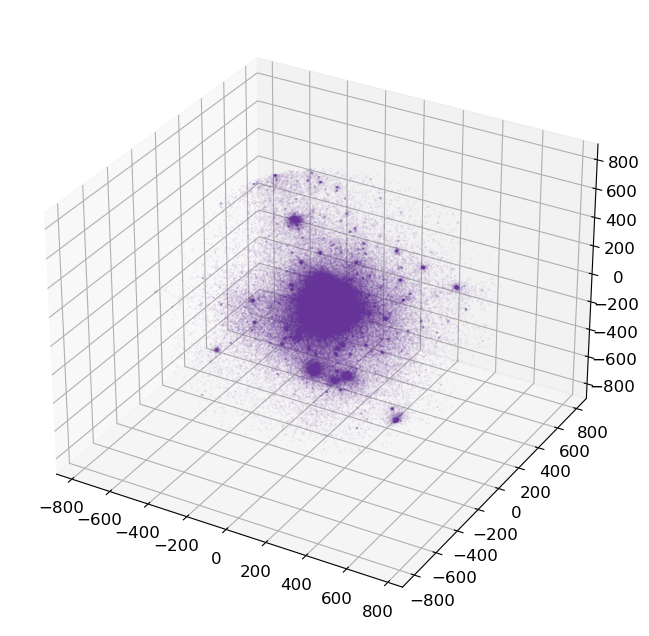

In [2]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
DM_fig = DM_raw
x_DM, y_DM, z_DM = DM_fig[:,0], DM_fig[:,1], DM_fig[:,2]
cut = 10
x, y, z = x_DM[1::cut], y_DM[1::cut], z_DM[1::cut]
ax.scatter(x, y, z, alpha=0.9, c='rebeccapurple', s=0.001)
plt.show()

In [1]:
from shared.preface import *
import shared.functions as fct

sim = 'L012N376'
snap = '0036'
halo_ID = 2
halo_ID_rvir = 298.73*kpc
DM_range_kpc = 800*kpc

fname3 = f'Test_halos_inRange'
fct.read_DM_halos_inRange(sim, snap, halo_ID, DM_range_kpc, fname3)
DM_raw3 = np.load(f'{sim}/DM_pos_{fname3}.npy')
print('DM grav. bound to halos in range:', len(DM_raw3))

All halos in range: 1300
[  51   67  118  345  547  618  703  748  763  768 1072 1127 1139 1189
 1566 1693 2009 2045 2112 2173 2541 2599 2659 2677 2688 2917 2962 2993
 3155 3170 3193 3335 3355 3395 3418 3927 3969 4010 4123 4151 4457 4475
 4532 4585 4633 4703 4704 4908 4989]
Subhalos in range after limit: 49
[   2   51   67  118  345  547  618  703  748  763  768 1072 1127 1139
 1189 1566 1693 2009 2045 2112 2173 2541 2599 2659 2677 2688 2917 2962
 2993 3155 3170 3193 3335 3355 3395 3418 3927 3969 4010 4123 4151 4457
 4475 4532 4585 4633 4703 4704 4908 4989]
DM grav. bound to halos in range: 1864589


In [3]:
print('DM grav. bound to halos in range:', len(DM_raw3))

DM grav. bound to halos in range: 1864589


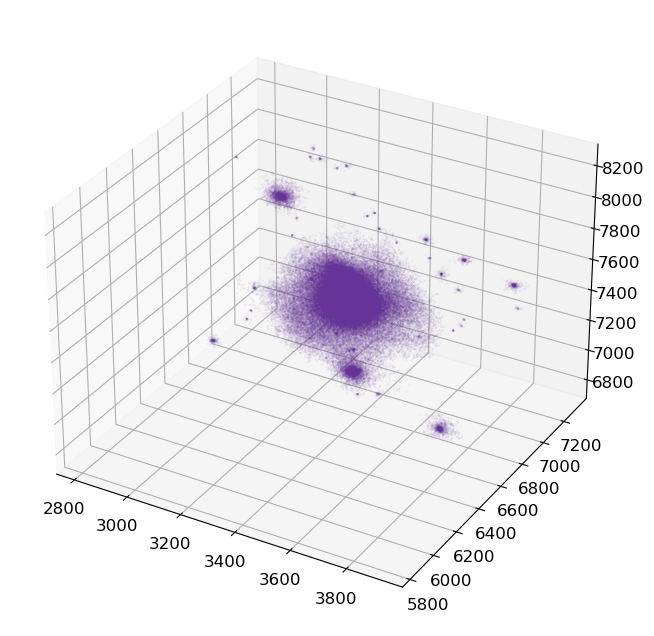

In [2]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
DM_fig = DM_raw3
x_DM, y_DM, z_DM = DM_fig[:,0], DM_fig[:,1], DM_fig[:,2]
cut = 10
x, y, z = x_DM[1::cut], y_DM[1::cut], z_DM[1::cut]
ax.scatter(x, y, z, alpha=0.9, c='rebeccapurple', s=0.001)
plt.show()

In [ ]:
from shared.preface import *
import shared.functions as fct

# sim_ID = 'L006N188'
sim_ID = 'L012N376'

# Path to merger_tree file (has to have been generated with merger_tree.py)
tree_path = f'{pathlib.Path.cwd().parent}/neutrino_clustering_output_local/MergerTree/MergerTree_{sim_ID}.hdf5'

with h5py.File(tree_path) as tree:
    Masses = tree['Assembly_history/Mass'][:10,:]
    zeds = tree['Assembly_history/Redshift']
    
    masses = np.asarray(Masses)
    z = np.asarray(zeds)

    fig = plt.figure()

    for m in masses:
        plt.semilogy(z, m, label=f'{m[0]:.2e}')

    plt.title(u'Starting mass in labels ->')
    plt.xlabel('redshift')
    plt.ylabel('halo masses [Msun]')
    plt.legend()
    plt.show()

In [ ]:
for s in NUMS_SNAPSHOTS[3:]:
    g = np.load(
        f'CubeSpace/fin_grid_L006N188_snapshot_{s}_1.89e+12Msun_800.0kpc.npy'
    )
    c = np.load(
        f'CubeSpace/DM_count_L006N188_snapshot_{s}_1.89e+12Msun_800.0kpc.npy'
    )
    
    print(g.shape, c.sum())

### Snippets for cell division function.

In [ ]:
parent_GRID_S = GRID_S
sub8_GRID_S = parent_GRID_S/2.
sub8_raw = fct.grid_3D(sub8_GRID_S, sub8_GRID_S)
# print(sub8_raw/kpc)

pcs = 5  # amount of parent cells
sub8_temp = np.tile(sub8_raw, (pcs,1)).reshape((pcs, 8, 3))
# print(sub8_temp/kpc, sub8_temp.shape)

parent_cc = np.zeros((pcs,1,3))
parent_cc[1,...] += 2
parent_cc[4,...] += 2
parent_cc *= kpc
print(parent_cc/kpc)

sub8_coords = np.reshape(sub8_temp + parent_cc, (pcs*8, 1, 3))
print(sub8_coords/kpc)

In [ ]:
DM_count = np.zeros(len(parent_cc))
DM_count[[1,3]] += 1
trimmed_cc = np.delete(parent_cc, np.s_[DM_count==0], axis=0)
print(trimmed_cc)

In [ ]:
rand_DM = np.random.random((2,4,3))
rand_DM[:,3:,:] = np.nan
# print(rand_DM)

DM_re = rand_DM.reshape((2*4,3))
DM_sort = np.sort(DM_re, axis=0)
# print(DM_sort)

max_row = np.count_nonzero(~np.isnan(DM_sort[:,0]))
# print(max_row)

DM_trunc = np.delete(DM_sort, np.s_[max_row:], axis=0)

# print(DM_trunc)

DM_unique = np.unique(DM_trunc, axis=1)
# print(DM_unique)

len1 = len(DM_unique)
len2 = len(DM_trunc)
print(len1==len2)

In [ ]:
DM_nonan = DM_reset[~np.isnan(DM_reset)]
print(DM_nonan.shape)

len1 = len(np.unique(DM_nonan.flatten()))
len2 = len(DM_nonan.flatten())
print(len1==len2, len1, len2)

In [ ]:
DM_pos = np.random.randint(-10, 10, (2,5,3))
DM_pos = np.asarray(DM_pos, dtype=np.float64)
DM_pos[:,1:3,:] = np.nan
print(DM_pos)

ind_2D = DM_pos[:,:,0].argsort(axis=1)
ind_3D = np.repeat(np.expand_dims(ind_2D, axis=2), 3, axis=2)

DM_pos_sort = np.take_along_axis(DM_pos, ind_3D, axis=1)
print(DM_pos_sort)

In [ ]:
parts = np.random.randint(-10, 10, (2,5,3))

print(parts)

cell_len = np.ones((len(parts),1))*7
print(cell_len.shape)
cell_len[0] = 5

parts_in = np.asarray(
    (np.abs(parts[:,:,0]) <= cell_len) &
    (np.abs(parts[:,:,1]) <= cell_len) &
    (np.abs(parts[:,:,2]) <= cell_len)
)

print(parts_in)

parts = np.asarray(parts, dtype=np.float64)

parts[~parts_in] = np.nan

print(parts)

### Output of cell disvision.

In [ ]:
fin_grid = np.load('CubeSpace/fin_grid_L006N188_snapshot_0036.npy')
DM_raw = np.load(
    'CubeSpace/DM_positions_L006N188_snapshot_0036_2.59e+11Msun.npy')
DM_count = np.load('CubeSpace/DM_count_L006N188_snapshot_0036.npy')
cell_com = np.load('CubeSpace/cell_com_L006N188_snapshot_0036.npy')
cell_gen = np.load('CubeSpace/cell_gen_L006N188_snapshot_0036.npy')

print(fin_grid.shape, DM_raw.shape, DM_count.shape, cell_com.shape, cell_gen.shape)
print(np.sum(DM_count))
print(type(cell_com.shape[0]))

cell_com_rep = np.repeat(
        np.expand_dims(cell_com, axis=1), fin_grid.shape[0], axis=1
    )
print(cell_com_rep.shape)

### Selecting only certain element for each column of 3D array.

In [ ]:
a = np.zeros((3,3), int)
np.fill_diagonal(a, 1)
print(a)

t0 = np.arange(9).reshape(3,3)
print(t0[~a.astype(dtype=bool)].reshape(3,2))

a = np.repeat(np.expand_dims(a, axis=2), 3, axis=2)
# print(a)

t1 = np.arange(27).reshape(3,3,3)
# print(t1)
print(t1[~a.astype(dtype=bool)].reshape(3,2,3))

## Argparse

Functions that use/make files:
- read_DM_positions
- cell_division
- cell_gravity_3D
- load_grid
- load_u_sim
- load_x_sim

Scripts that use/make files:
- discrete_precalculations_MW.py
- discrete_simulation_MW.py
- merger_tree.py
- smooth_simulation.py

In [ ]:
class NuParser(object):

    input_x: str

    def __init__(self):
        
        parser = argparse.ArgumentParser(
            description="Argument Parser for Neutrino Clustering pipeline."
        )

        parser.add_argument(
            "-x",
            "--long_name_x",
            help="explain what x does",
            type=str,
            required=True
        )

        args = parser.parse_args()

        self.input_x = args.long_name_x


        print("{Parsed arguments:")
        print("---------------------\n")
        print(f"Parameter x: {self.input_x}")


## Tests

### Rearranging 2D array along one axis.

In [ ]:
x2D = np.arange(6).reshape(2,3)
print(x2D)

ind2D = np.array([[1,0,2], [2,1,0]])

ax0 = np.arange(x2D.shape[0])[:,None]

print(ax0.shape, ind2D.shape)

new_x2D = x2D[ax0, ind2D]
print(new_x2D)

### Rearranging 3D array along one axis.

In [ ]:
x3D = np.arange(18).reshape(2,3,3)
print(x3D)
ind3D = np.array([[1,0,2], [2,1,0]])[:,:,None]

ax0 = np.arange(x3D.shape[0])[:,None,None]
ax2 = np.arange(x3D.shape[2])[None,None,:]

new_x3D = x3D[ax0,ind3D,ax2]
print(new_x3D)

### Conversions between momentum to velocity.

In [ ]:
NU_MASSES = np.array([0.01, 0.05, 0.1, 0.3])*eV
Vs = 100
LOWER = 0.01*T_CNB
UPPER = 400*T_CNB

# Momentum range.
MOMENTA = np.geomspace(LOWER, UPPER, Vs)


# Without Lorentz factor.
v_mins = np.zeros(len(NU_MASSES))
v_maxs = np.zeros(len(NU_MASSES))
for i, m_nu in enumerate(NU_MASSES):
    v_km = MOMENTA / m_nu / (m/s)
    v_min, v_max = v_km[0], v_km[-1]
    print(f'(m/s) -> v_min = {v_min:.2f}, v_max = {v_max:.2f}, %c = {v_max/const.c.value*100:.2f} : for {m_nu} eV neutrino')

    v_mins[i] = v_min
    v_maxs[i] = v_max


# for m_nu in NU_MASSES:



# With Lorentz factor.
v_mins = np.zeros(len(NU_MASSES))
v_maxs = np.zeros(len(NU_MASSES))
for m_nu in NU_MASSES:
    v_km = 1/np.sqrt(m_nu**2/MOMENTA**2 + 1) / (m/s)
    v_min, v_max = v_km[0], v_km[-1]
    print(f'(m/s) -> v_min = {v_min:.2f}, v_max = {v_max:.2f}, %c = {v_max/const.c.value*100:.2f} : for {m_nu} eV neutrino')


#! Since the sim is using 0.3 eV mass, the max. velocity present in the sim is 
#! ~20% of c, not the ~98% of the 0.01 eV neutrino (see output of cell).


# Back to momentum to check formulas & functions.


### Coordinates of Andromeda (AG) and the Virgo Cluster (VC).

In [ ]:
# Cross-check with values in Mertsch et al. (2020).
# -> x and y coords. are switched, since our setup is different,
# and my x (their y) coords. differ by 8.5 kpc due to placement of sun
# on our x-axis.
coords_VC = fct.halo_pos(GLAT_VC, GLON_VC, DIST_VC/kpc)
print(coords_VC, 'in kpc')
coords_AG = fct.halo_pos(GLAT_AG, GLON_AG, DIST_AG/kpc)
print(coords_AG, 'in kpc')

### Values in Table 1 of Mertsch et al. (2020).

In [ ]:
Rvir_Tab1 = fct.R_vir_fct(0, Mvir_MW)
print(Rvir_Tab1/kpc)
c_vir_Tab1 = fct.c_vir(0, Mvir_MW, Rvir_MW, Rs_MW)
Rs_Tab1 = Rvir_Tab1 / c_vir_Tab1
print(Rs_Tab1/kpc)

### Critical density of universe.

In [ ]:
rho_crit_today = fct.rho_crit(0)
print(f'{rho_crit_today*(Msun/kpc**3)/(kg/m**3):.2e} kg/m^3') 

### Time Variable s(z) and comparison to age of universe.

In [ ]:
# In s_of_z function we use
H0_mod = H0/ (1/s)
print(H0_mod)

test_z = 1
s_val = fct.s_of_z(test_z)
print(f'Value of time variable s in seconds at redhshift {test_z}:','\n', s_val)
print(
    'Age of universe comparison: \n', 
    f'"Observed/measured": {t0/s:.2e}, i.e. {t0/Gyr:.2f} Gyr \n', 
    f'What we use in s_of_z function: {1/H0/s:.2e}, i.e. {1/H0/Gyr:.2f} Gyr'
)

### Integrals for cosmic time.

In [ ]:
def t_integrand_a(a):

    # We need value of H0 in units of 1/s.
    H0_val = H0/(1/s)

    a_dot = np.sqrt(Omega_M/a**3 + Omega_L)*H0_val*a
    t_int = 1./a_dot

    return t_int

t, err = quad(t_integrand_a, 0, 1)
t_uni, err_uni = t, err
print(t_uni*s/Gyr, err_uni*s/Gyr)

In [ ]:
def t_integrand_z(z):

    # We need value of H0 in units of 1/s.
    H0_val = H0/(1/s)

    a_dot = np.sqrt(Omega_M*(1.+z)**3 + Omega_L)*H0_val*(1.+z)
    t_int = 1./a_dot

    return t_int

t, err = quad(t_integrand_z, 0, np.inf)
t_uni, err_uni = t, err
print(t_uni*s/Gyr, err_uni*s/Gyr)

### Fermi-Dirac distribution.

In [ ]:
p_test_range = np.linspace(0.01, 10)*T_CNB
FD_range = fct.Fermi_Dirac(p_test_range)

plt.loglog(p_test_range/T_CNB, FD_range)
plt.show()

### Redshift array for integration steps.

In [ ]:
# Linear spacing.
# late_steps = 200
# early_steps = 100
# Z_START, Z_STOP, Z_AMOUNT = 0., 4., late_steps+early_steps
# z_late = np.linspace(0,1,late_steps)
# z_early = np.linspace(1.01,4,early_steps)
# ZEDS = np.concatenate((z_late, z_early))

# Logarithmic spacing.
Z_START, Z_STOP, Z_AMOUNT = 0., 4., 300-1  # -1 to compensate np.insert of z=4
Z_START_LOG = 1e-1
zeds_pre = np.geomspace(Z_START_LOG, Z_STOP, Z_AMOUNT) - Z_START_LOG
ZEDS = np.insert(zeds_pre, len(zeds_pre), 4.)

plt.scatter(ZEDS, ZEDS, s=1)
plt.show()
print(ZEDS[0:10], ZEDS[-1])

### Redshift z of each snapshot.

### NFW density profile fct.

In [ ]:
r_range = np.geomspace(1e-3, 100, 100)*kpc
NFW_vals = fct.NFW_profile(r_range, rho0_MW, Rs_MW)
plt.loglog(r_range/kpc, NFW_vals/(GeV/cm**3))

### Typical grav. potential gradient vectors in spher. symmetric simulation.

In [ ]:
z = 0

# For position of Sun/Earth.
x_i = X_SUN*kpc
grad_MW = fct.dPsi_dxi_NFW(x_i, z, rho0_MW, Mvir_MW, Rvir_MW, Rs_MW, 'MW')
grad_MW /= (kpc/s**2)
print('Position of Sun/Earth:')
print(grad_MW)
print(np.sqrt(np.sum(grad_MW**2)), '\n')

# For a position closer to the center of the halo.
x_i = np.array([0.01, 0, 0])*kpc
grad_MW = fct.dPsi_dxi_NFW(x_i, z, rho0_MW, Mvir_MW, Rvir_MW, Rs_MW, 'MW')
grad_MW /= (kpc/s**2)
print('Position close to center:')
print(grad_MW)
print(np.sqrt(np.sum(grad_MW**2)), '\n')

# For a position further away to the center of the halo.
x_i = np.array([333., 0, 0])*kpc
grad_MW = fct.dPsi_dxi_NFW(x_i, z, rho0_MW, Mvir_MW, Rvir_MW, Rs_MW, 'MW')
grad_MW /= (kpc/s**2)
print('Position at virial radius:')
print(grad_MW)
print(np.sqrt(np.sum(grad_MW**2)))

### Test memory sizes

In [ ]:
mem = np.random.random(size=(40000000,3))
print(mem.shape, (mem.nbytes)/1e6)

mem0 = np.empty((40000000,3))
print(mem0.shape, (mem0.nbytes)/1e6)

40 million cells have ~ 1GB memory. There shouldn't be memory issues with the final arrays, especially with the SNELLIUS cluster memory nodes of ~64GB or even ~128GB.